In [18]:
!pip -q install ncps pytorch-lightning

In [19]:
import matplotlib.pyplot as plt
import pandas as pd
import os
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping
from keras.layers import LSTM
from keras.layers import Dropout
import torch
import torch.nn as nn
from ncps.wirings import AutoNCP
from ncps.torch import LTC
import pytorch_lightning as pl
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from keras.layers import SimpleRNN
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [20]:
def get_all_cities(data):
    cleaned_data = data.dropna()
    # make a separate dataframe for each city
    amaravati = cleaned_data[cleaned_data.City == 'Amaravati']
    amritsar = cleaned_data[cleaned_data.City == 'Amritsar']
    chandigarh = cleaned_data[cleaned_data.City == 'Chandigarh']
    delhi = cleaned_data[cleaned_data.City == 'Delhi']
    gurugram = cleaned_data[cleaned_data.City == 'Gurugram']
    hyderabad = cleaned_data[cleaned_data.City == 'Hyderabad']
    kolkata = cleaned_data[cleaned_data.City == 'Kolkata']
    patna = cleaned_data[cleaned_data.City == 'Patna']
    visakhapatnam = cleaned_data[cleaned_data.City == 'Visakhapatnam']
    return amaravati, amritsar, chandigarh, delhi, gurugram, hyderabad, kolkata, patna, visakhapatnam

In [21]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler, RobustScaler, StandardScaler

def preprocess_data(X, y, scale_method = 'default'):
    if scale_method == 'default':
        y = y/y.max()
        X = X/X.max()
    else:
        # if scale_method == 'standard':
        #     scaler = StandardScaler()
        if scale_method == 'minmax':
            scaler = MinMaxScaler()
        elif scale_method == 'maxabs':
            scaler = MaxAbsScaler()
        # elif scale_method == 'robust':
        #     scaler = RobustScaler()
        else:
            raise ValueError("Invalid scaling method")
        X = scaler.fit_transform(X)
        y = y.values
        y = y.reshape(-1,1)
        y = scaler.fit_transform(y)

    if scale_method == 'default':
        return X, y, None
    else:
        return X, y, scaler

def clean_data(data):
    cleaned_data = data.dropna()
    gasses = cleaned_data.select_dtypes(include = np.float64)
    corr = gasses.corr().AQI
    col_to_drop = corr[abs(corr) < 0.45].index
    gasses = gasses.drop(columns = col_to_drop)
    y = gasses.AQI
    X = gasses.drop(columns = 'AQI')
    return X, y

In [22]:
def print_model_performance(mse, r2, mae, mape, model_name = 'Linear Regression', scale_method = 'default'):
    print("\n For Model: {} with Scale Method: {}".format(model_name, scale_method))
    print("Mean Squared Error:", mse)
    print("R-squared:", r2)
    print("Mean Absolute Error:", mae)
    print("Mean Absolute Percentage Error:", mape)

def log_results(model_name, scale_method, split, mse, r2, mae, mape, city=""):
    base_df = pd.DataFrame(columns = ['Model', 'Scale Method', 'Data Split', 'City', 'MSE', 'R2', 'MAE', 'MAPE'])
    new_df = pd.DataFrame([[model_name, scale_method, split, city, mse, r2, mae, mape]], columns = ['Model', 'Scale Method', 'Data Split', 'City', 'MSE', 'R2', 'MAE', 'MAPE'])
    if os.path.exists('results.csv'):
        base_df = pd.read_csv('results.csv')
        base_df = pd.concat([base_df, new_df])
        base_df.to_csv('results.csv', index = False)
    else:
        new_df.to_csv('results.csv', index = False)

def plot_predictions(y_test, y_pred, scale_method = 'default', model_name = 'Linear Regression', split=0.3, city = ""):
    plt.figure(figsize=(10, 5))
    y_test = np.array(y_test)
    y_pred = np.array(y_pred)
    y_test = y_test[:int(split * len(y_test))]
    y_pred = y_pred[:int(split * len(y_pred))]
    plt.plot(y_test, label='True')
    plt.plot(y_pred, label='Predicted')
    plt.title("True vs Predicted AQI of {} using {} with Scale Method: {}".format(city, model_name, scale_method))
    plt.xlabel("Observation")
    plt.ylabel("AQI")
    plt.legend()
    plt.show()

In [23]:
def linear_regression_model(data, scale_method = 'default', plot_split=0.3, data_split=0.2, city=""):
    X, y = clean_data(data)
    # y_max = y.max()
    X, y, scaler = preprocess_data(X, y, scale_method)
    X_train = X[:int(data_split * len(X))]
    X_test = X[int(data_split * len(X)):]
    y_train = y[:int(data_split * len(y))]
    y_test = y[int(data_split * len(y)):]
    model = LinearRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
    print_model_performance(mse, r2, mae, mape, model_name='Linear Regression', scale_method=scale_method)
    plot_predictions(y_test, y_pred, scale_method=scale_method, model_name='Linear Regression', split=plot_split, city=city)
    log_results('Linear Regression', scale_method, data_split, mse, r2, mae, mape, city=city)

In [24]:
def rf_regression_model(data, scale_method = 'default', plot_split=0.3, data_split=0.2, city=""):
    X, y = clean_data(data)
    # y_max = y.max()
    X, y, scaler = preprocess_data(X, y, scale_method)
    X_train = X[:int(data_split * len(X))]
    X_test = X[int(data_split * len(X)):]
    y_train = y[:int(data_split * len(y))]
    y_test = y[int(data_split * len(y)):]
    model = RandomForestRegressor()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
    print_model_performance(mse, r2, mae, mape, model_name='Random Forest', scale_method=scale_method)
    plot_predictions(y_test, y_pred, scale_method=scale_method, model_name='Random Forest', split=plot_split, city=city)
    log_results('Random Forest', scale_method, data_split, mse, r2, mae, mape, city=city)

In [25]:
def nn_model(data, scale_method = 'default', plot_split = 0.3, data_split=0.2, city=""):
    X, y = clean_data(data)
    # y_max = y.max()
    X, y, scaler = preprocess_data(X, y, scale_method)
    X_train = X[:int(data_split * len(X))]
    X_test = X[int(data_split * len(X)):]
    y_train = y[:int(data_split * len(y))]
    y_test = y[int(data_split * len(y)):]
    model = Sequential()
    model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(1, activation='linear'))
    model.compile(loss='mean_squared_error', optimizer='adam')
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)
    history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test), callbacks=[es], verbose=0)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    try:
        mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
    except:
        # convert to one dimensional array
        y_test = np.array(y_test)
        y_pred = np.array(y_pred)
        mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
    print_model_performance(mse, r2, mae, mape, model_name='Neural Network', scale_method=scale_method)
    plot_predictions(y_test, y_pred, scale_method=scale_method, model_name='Neural Network', split=plot_split, city=city)
    log_results('Neural Network', scale_method, data_split, mse, r2, mae, mape, city=city)


In [26]:
def lstm_model(data, scale_method = 'maxabs', plot_split = 0.3, data_split=0.2, embedding_size = 256, dropout = False, city=""):
    if scale_method == 'default':
        print("Default scaling method not supported for LSTM...")
        scale_method = "minmax"
    X, y = clean_data(data)
    # y_max = y.max()
    X, y, scaler = preprocess_data(X, y, scale_method)
    X_train = X[:int(data_split * len(X))]
    X_test = X[int(data_split * len(X)):]
    y_train = y[:int(data_split * len(y))]
    y_test = y[int(data_split * len(y)):]
    X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
    X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))
    model = Sequential()
    model.add(LSTM(embedding_size, input_shape=(X_train.shape[1], X_train.shape[2]),))
    if dropout:
        model.add(Dropout(0.2))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50)
    history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test), callbacks=[es], verbose=0)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
    print_model_performance(mse, r2, mae, mape, model_name='LSTM', scale_method=scale_method)
    plot_predictions(y_test, y_pred, scale_method=scale_method, model_name='LSTM', split=plot_split, city=city)
    log_results('LSTM', scale_method, data_split, mse, r2, mae, mape, city=city)

In [27]:
def arima_model(data, scale_method = 'minmax', plot_split = 0.3, data_split=0.2, order=(5,1,0), city=""):
    if scale_method == 'default':
        print("SARIMAX model does not support 'default' scaling method")
        scale_method = "minmax"
    X, y = clean_data(data)
    # y_max = y.max()
    X, y, scaler = preprocess_data(X, y, scale_method)
    X_train = X[:int(data_split * len(X))]
    X_test = X[int(data_split * len(X)):]
    y_train = y[:int(data_split * len(y))]
    y_test = y[int(data_split * len(y)):]
    model = SARIMAX(y_train, order=order)
    model_fit = model.fit(disp=0)
    y_pred = model_fit.predict(start=len(y_train), end=len(y_train)+len(y_test)-1, dynamic=False)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
    print_model_performance(mse, r2, mae, mape, model_name='SARIMAX', scale_method=scale_method)
    plot_predictions(y_test, y_pred, scale_method=scale_method, model_name='SARIMAX', split=plot_split, city=city)
    log_results('SARIMAX', scale_method, data_split, mse, r2, mae, mape, city=city)

In [28]:
def holt_winters_model(data, scale_method = 'default', plot_split = 0.3, data_split=0.2, city=""):
    # if scale_method == 'default':
    #     raise ValueError("Holt-Winters model does not support 'default' scaling method")
    X, y = clean_data(data)
    # y_max = y.max()
    X, y, scaler = preprocess_data(X, y, scale_method)
    X_train = X[:int(data_split * len(X))]
    X_test = X[int(data_split * len(X)):]
    y_train = y[:int(data_split * len(y))]
    y_test = y[int(data_split * len(y)):]
    model = ExponentialSmoothing(y_train, trend='add', seasonal='add', seasonal_periods=366)
    model_fit = model.fit()
    y_pred = model_fit.predict(start=len(y_train), end=len(y_train)+len(y_test)-1)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
    print_model_performance(mse, r2, mae, mape, model_name='Holt-Winters', scale_method=scale_method)
    plot_predictions(y_test, y_pred, model_name='Holt-Winters', scale_method=scale_method, split=plot_split, city=city)
    log_results('Holt-Winters', scale_method, data_split, mse, r2, mae, mape, city=city)

In [29]:
# implemment RNN model
def rnn_model(data, scale_method = 'default', plot_split = 0.3, data_split=0.2, city=""):
    if scale_method == 'default':
        print("RNN model does not support 'default' scaling method.")
        scale_method = "minmax"
    X, y = clean_data(data)
    # y_max = y.max()
    X, y, scaler = preprocess_data(X, y, scale_method)
    X_train = X[:int(data_split * len(X))]
    X_test = X[int(data_split * len(X)):]
    y_train = y[:int(data_split * len(y))]
    y_test = y[int(data_split * len(y)):]
    X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
    X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))
    model = Sequential()
    model.add(SimpleRNN(312, input_shape=(X_train.shape[1], X_train.shape[2]),))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50)
    history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test), callbacks=[es], verbose=0)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
    print_model_performance(mse, r2, mae, mape, model_name='RNN', scale_method=scale_method)
    plot_predictions(y_test, y_pred, scale_method=scale_method, model_name='RNN', split=plot_split, city=city)
    log_results('RNN', scale_method, data_split, mse, r2, mae, mape, city=city)

In [30]:
# implement LTC regressor
import numpy as np
class SequenceLearner(pl.LightningModule):
    def __init__(self, model, lr=0.005):
        super().__init__()
        self.model = model
        self.lr = lr

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat, _ = self.model.forward(x)
        y_hat = y_hat.view_as(y)
        loss = nn.MSELoss()(y_hat, y)
        self.log("train_loss", loss, prog_bar=True)
        return {"loss": loss}

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat, _ = self.model.forward(x)
        y_hat = y_hat.view_as(y)
        loss = nn.MSELoss()(y_hat, y)

        self.log("val_loss", loss, prog_bar=True)
        return loss

    def test_step(self, batch, batch_idx):
        # Here we just reuse the validation_step for testing
        return self.validation_step(batch, batch_idx)

    def configure_optimizers(self):
        return torch.optim.Adam(self.model.parameters(), lr=self.lr)

def ltc_model(data, scale_method = 'maxabs', plot_split = 0.3, data_split=0.2, embedding_size = 256, dropout = False, city=""):
    # if scale_method == 'default':
    #     print("Default scaling method not supported for LTC... switching to maxabs")
    #     scale_method = 'maxabs'
    X, y = clean_data(data)
    X, y, scaler = preprocess_data(X, y, scale_method)
    # X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, shuffle=False)
    X_train = X[:int(data_split * len(X))]
    X_test = X[int(data_split * len(X)):]
    y_train = y[:int(data_split * len(y))]
    y_test = y[int(data_split * len(y)):]
    X_train = np.array(X_train)
    X_test = np.array(X_test)
    y_train = np.array(y_train)
    y_test = np.array(y_test)
    X_train = torch.Tensor(X_train)
    X_test = torch.Tensor(X_test)
    y_train = torch.Tensor(y_train)
    y_test = torch.Tensor(y_test)
    dataloader = DataLoader(
        TensorDataset(X_train, y_train), batch_size=1, shuffle=False, num_workers=4
    )
    out_features = 1
    in_features = X_train.shape[1]
    wiring = AutoNCP(embedding_size, out_features)
    ltc_model = LTC(in_features, wiring, batch_first=True)
    learn = SequenceLearner(ltc_model, lr=0.01)
    trainer = pl.Trainer(
        max_epochs=150,
        # gradient_clip_val=1,
    )
    trainer.fit(learn, dataloader)
    y_pred, _ = ltc_model.forward(X_test)
    y_pred = y_pred.detach().numpy()
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    # mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
    mape=0
    print_model_performance(mse, r2, mae, mape, model_name='LTC', scale_method=scale_method)
    plot_predictions(y_test, y_pred, scale_method=scale_method, model_name='LTC', split=plot_split, city=city)
    log_results('LTC 150', scale_method, data_split, mse, r2, mae, mape, city=city)


In [31]:
def run_all_methods_on_model(data, model_name, data_split=0.2, plot_split=0.3, city=""):
    scalers = ['default', 'minmax', 'maxabs',]
    for scaler in scalers:
        if model_name == 'sarimax':
            if scaler == 'default':
                print("default scaler not supported for SARIMAX model...")
                pass
            arima_model(data, scaler, data_split=data_split, plot_split=plot_split, city=city)
        # elif model_name == 'holt_winters':
        #     holt_winters_model(data, scaler, data_split=data_split, plot_split=plot_split, city=city)
        if model_name == 'linear':
            linear_regression_model(data, scaler, data_split=data_split, plot_split=plot_split, city=city)
        elif model_name == 'nn':
            nn_model(data, scaler, data_split=data_split, plot_split=plot_split, city=city)
        elif model_name == 'lstm':
            lstm_model(data, scaler, data_split=data_split, plot_split=plot_split, city=city)
        elif model_name == 'rnn':
            rnn_model(data, scaler, data_split=data_split, plot_split=plot_split, city=city)
        elif model_name == 'ltc':
            ltc_model(data, scaler, data_split=data_split, plot_split=plot_split, city=city)
        elif model_name == 'rf':
            rf_regression_model(data, scaler, data_split=data_split, plot_split=plot_split, city=city)
        else:
            raise ValueError("Invalid model type")
        pass

In [32]:
city_day = pd.read_csv('city_day.csv')
amaravati, amritsar, chandigarh, delhi, gurugram, hyderabad, kolkata, patna, visakhapatnam = get_all_cities(city_day)


 For Model: Linear Regression with Scale Method: default
Mean Squared Error: 0.008559520005450126
R-squared: 0.7193220686607971
Mean Absolute Error: 0.0776671113119799
Mean Absolute Percentage Error: 36.930156491423716


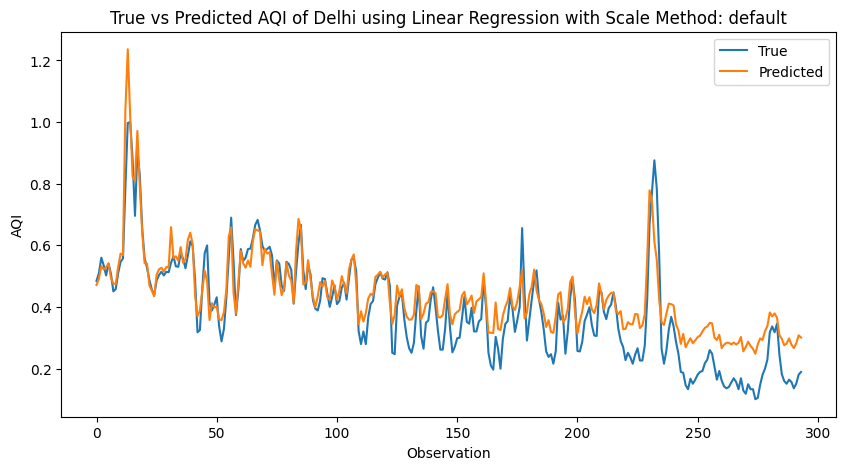

<ipython-input-23-72ce41a9f890>:15: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100



 For Model: Linear Regression with Scale Method: minmax
Mean Squared Error: 0.010011014312124096
R-squared: 0.7193220686607977
Mean Absolute Error: 0.08399462357541586
Mean Absolute Percentage Error: inf


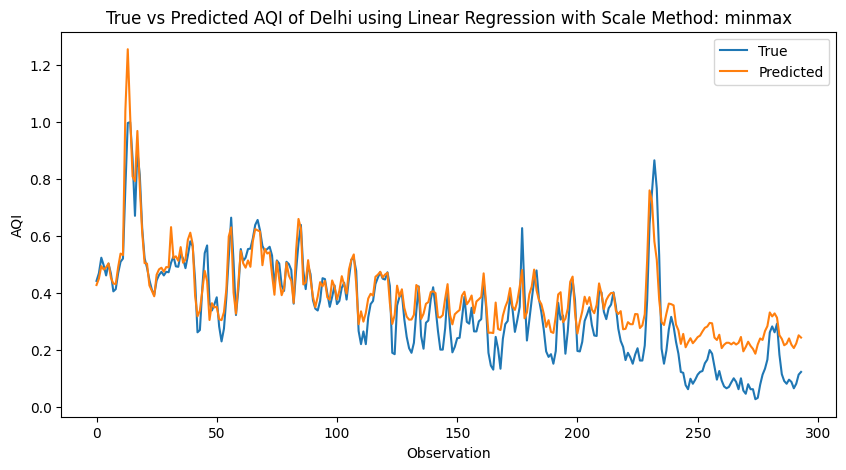


 For Model: Linear Regression with Scale Method: maxabs
Mean Squared Error: 0.008559520005450126
R-squared: 0.7193220686607971
Mean Absolute Error: 0.0776671113119799
Mean Absolute Percentage Error: 36.930156491423716


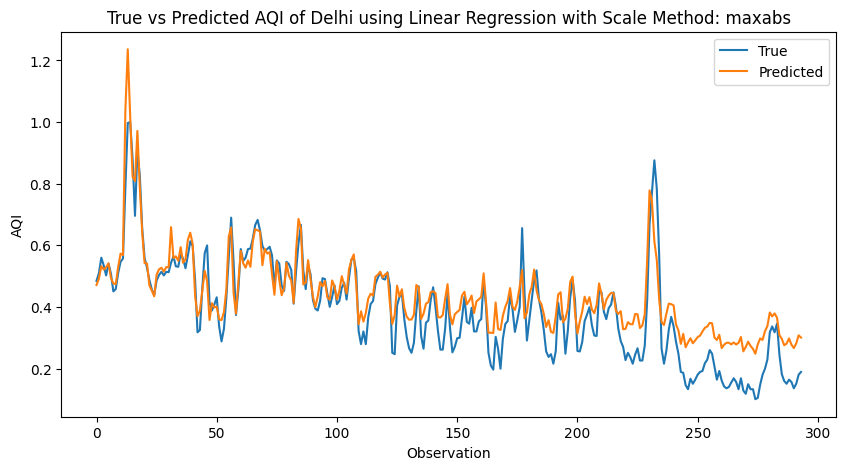


 For Model: Linear Regression with Scale Method: default
Mean Squared Error: 0.018376935155602913
R-squared: -0.05196479920353836
Mean Absolute Error: 0.10768573240389341
Mean Absolute Percentage Error: 17.131436683040455


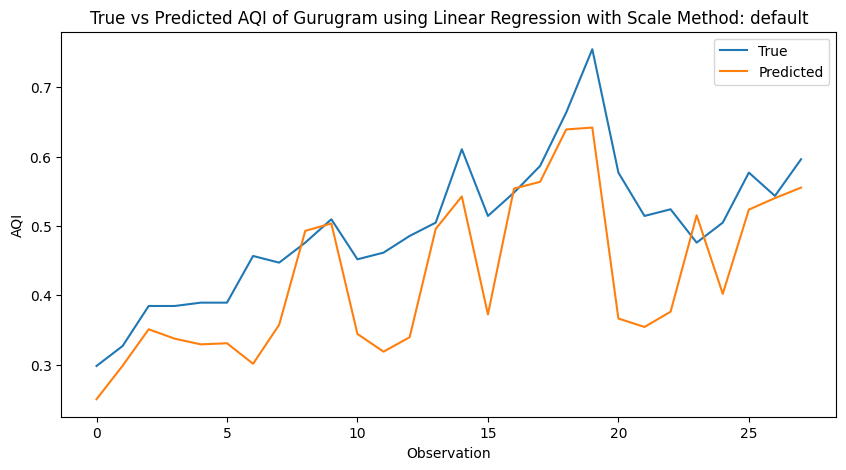


 For Model: Linear Regression with Scale Method: minmax
Mean Squared Error: 0.03581188786865474
R-squared: -0.051964799203537915
Mean Absolute Error: 0.15032639154369004
Mean Absolute Percentage Error: 37.437495771036005


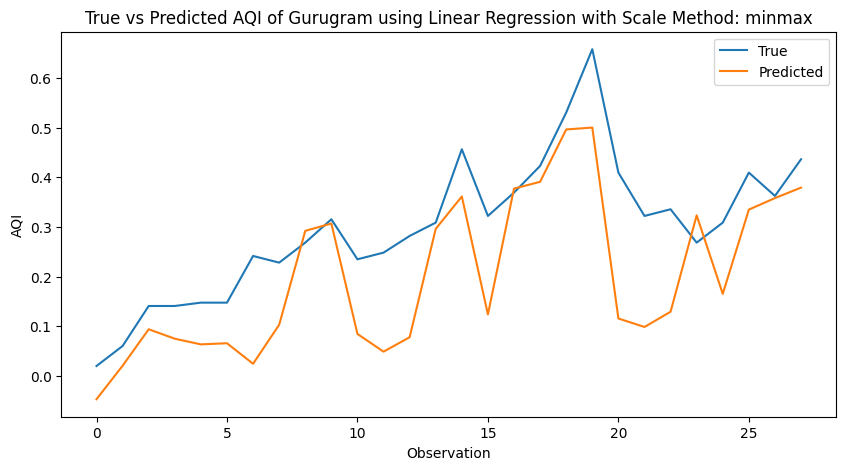


 For Model: Linear Regression with Scale Method: maxabs
Mean Squared Error: 0.018376935155602913
R-squared: -0.05196479920353836
Mean Absolute Error: 0.10768573240389341
Mean Absolute Percentage Error: 17.131436683040455


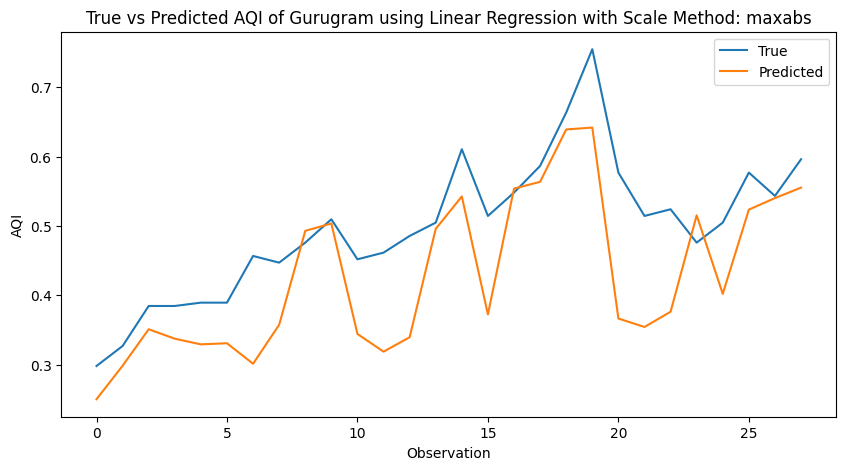


 For Model: Linear Regression with Scale Method: default
Mean Squared Error: 0.0015160037886075106
R-squared: 0.7268863228781258
Mean Absolute Error: 0.033284654694631974
Mean Absolute Percentage Error: 22.71748016446092


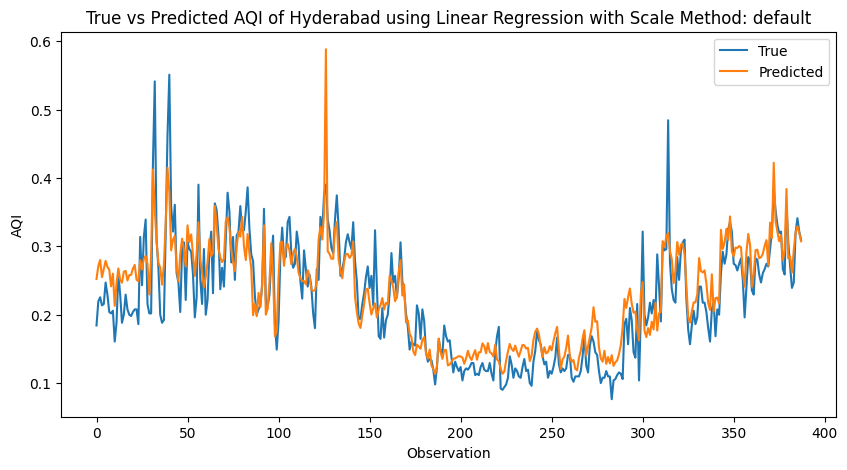

<ipython-input-23-72ce41a9f890>:15: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100



 For Model: Linear Regression with Scale Method: minmax
Mean Squared Error: 0.0017043174321377103
R-squared: 0.7268863228781264
Mean Absolute Error: 0.03529142181759312
Mean Absolute Percentage Error: inf


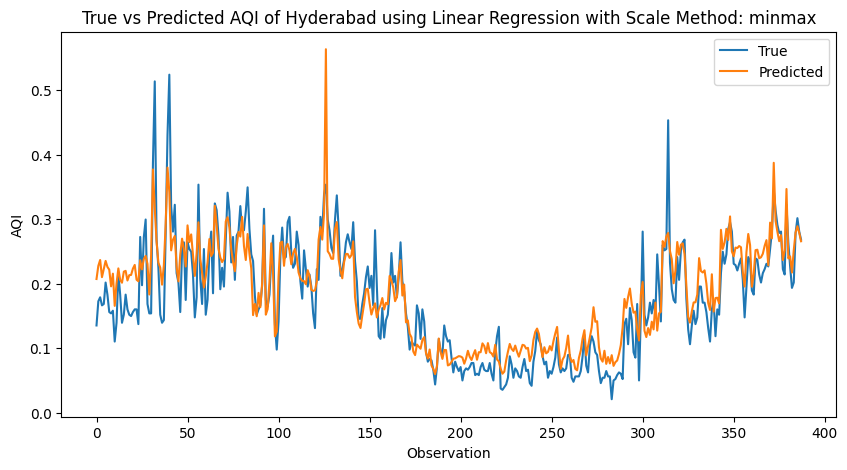


 For Model: Linear Regression with Scale Method: maxabs
Mean Squared Error: 0.0015160037886075106
R-squared: 0.7268863228781258
Mean Absolute Error: 0.033284654694631974
Mean Absolute Percentage Error: 22.71748016446092


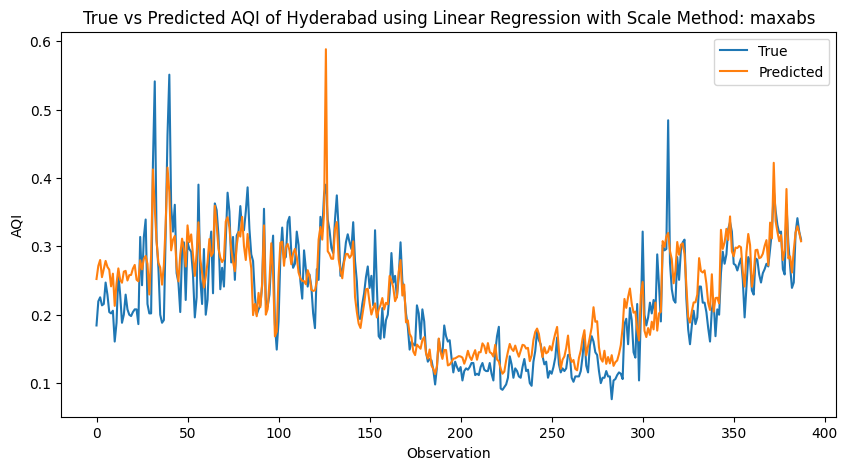


 For Model: Random Forest with Scale Method: default
Mean Squared Error: 0.009167314694760068
R-squared: 0.6993916805121807
Mean Absolute Error: 0.07910568836101643
Mean Absolute Percentage Error: 35.283016039499906


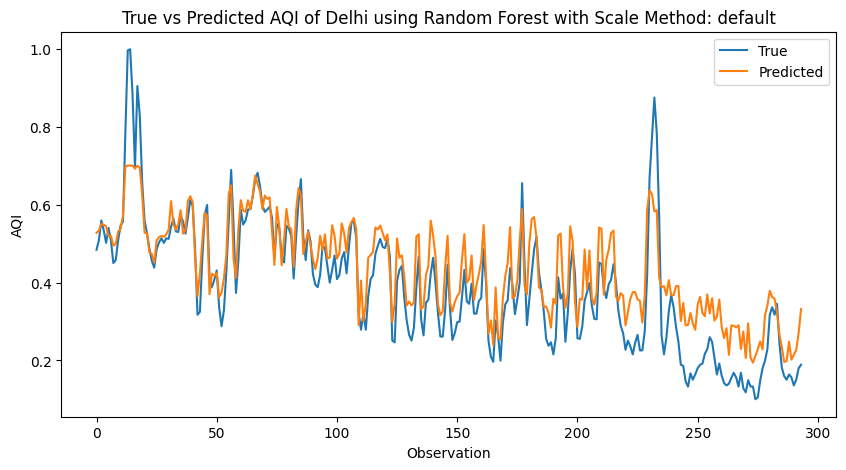

<ipython-input-24-4ecfe10499ed>:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y_train)
<ipython-input-24-4ecfe10499ed>:15: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100



 For Model: Random Forest with Scale Method: minmax
Mean Squared Error: 0.009583290343978023
R-squared: 0.7313141280885863
Mean Absolute Error: 0.08185624633239871
Mean Absolute Percentage Error: inf


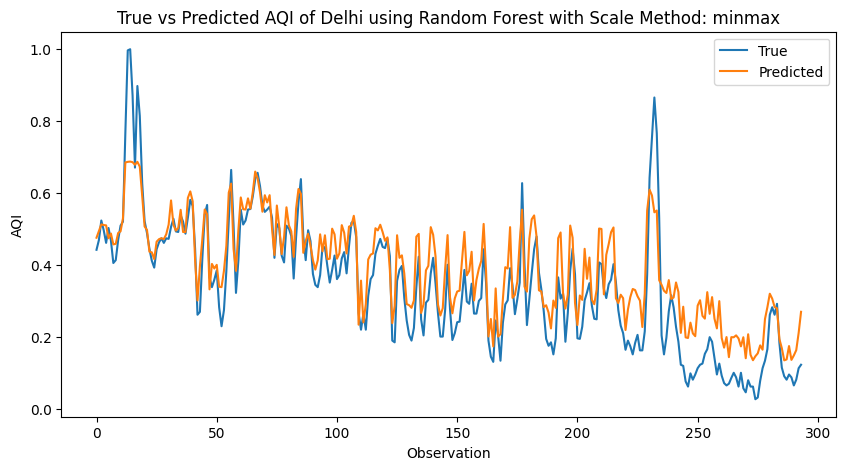

<ipython-input-24-4ecfe10499ed>:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y_train)



 For Model: Random Forest with Scale Method: maxabs
Mean Squared Error: 0.008891514660554182
R-squared: 0.7084355267810017
Mean Absolute Error: 0.07872206312362456
Mean Absolute Percentage Error: 77.18873646266954


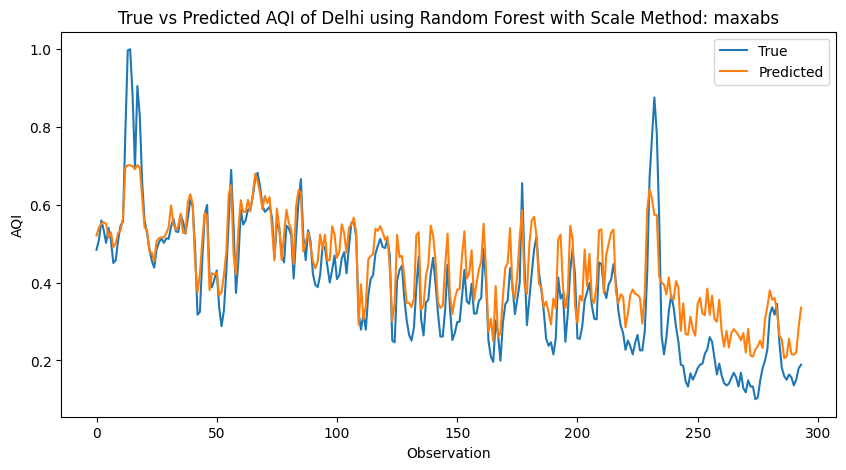


 For Model: Random Forest with Scale Method: default
Mean Squared Error: 0.014223768775232681
R-squared: 0.18577804531278475
Mean Absolute Error: 0.09203275240384616
Mean Absolute Percentage Error: 14.592050958246993


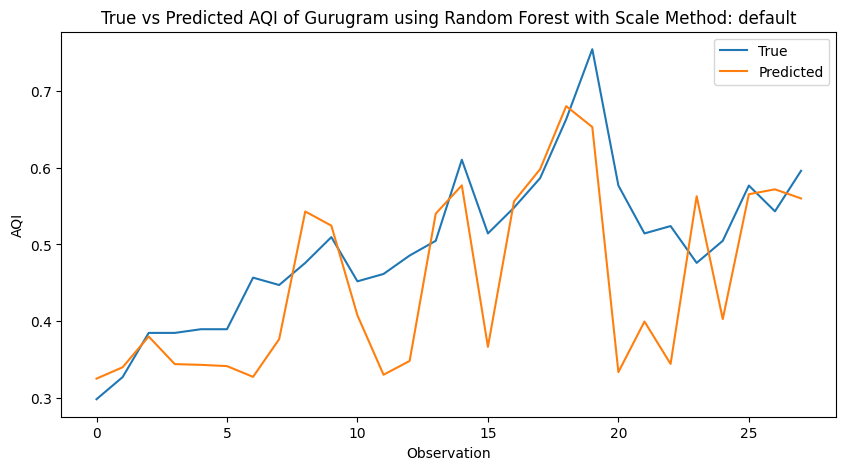

<ipython-input-24-4ecfe10499ed>:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y_train)



 For Model: Random Forest with Scale Method: minmax
Mean Squared Error: 0.02829033864840925
R-squared: 0.16897873340761504
Mean Absolute Error: 0.1298224272930649
Mean Absolute Percentage Error: 71.32087106001173


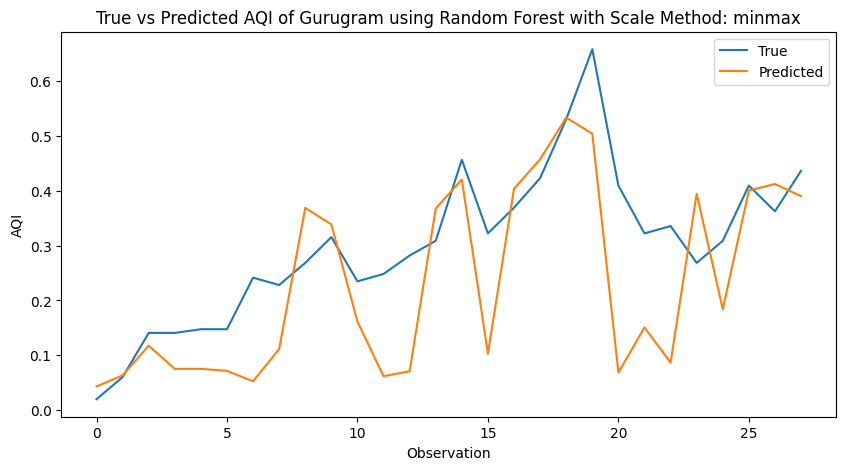

<ipython-input-24-4ecfe10499ed>:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y_train)



 For Model: Random Forest with Scale Method: maxabs
Mean Squared Error: 0.014081108981100527
R-squared: 0.19394442781443355
Mean Absolute Error: 0.09117337740384618
Mean Absolute Percentage Error: 25.348002723675084


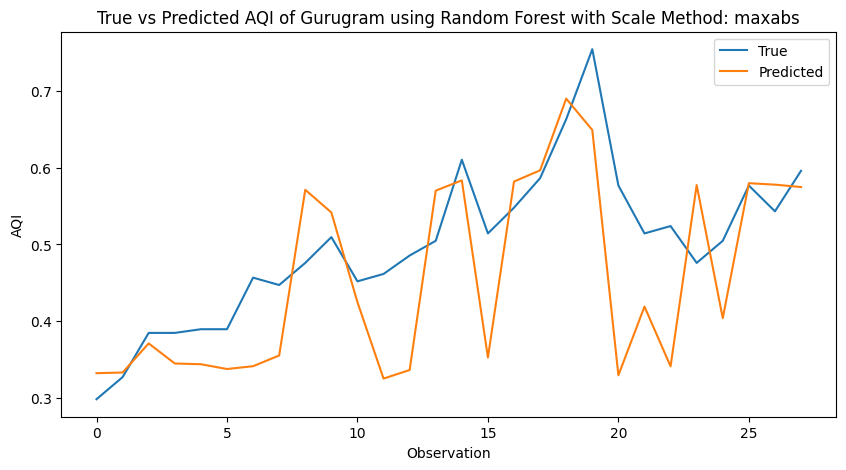


 For Model: Random Forest with Scale Method: default
Mean Squared Error: 0.001375619829617058
R-squared: 0.7521770111580185
Mean Absolute Error: 0.0291243546067075
Mean Absolute Percentage Error: 18.48632897535858


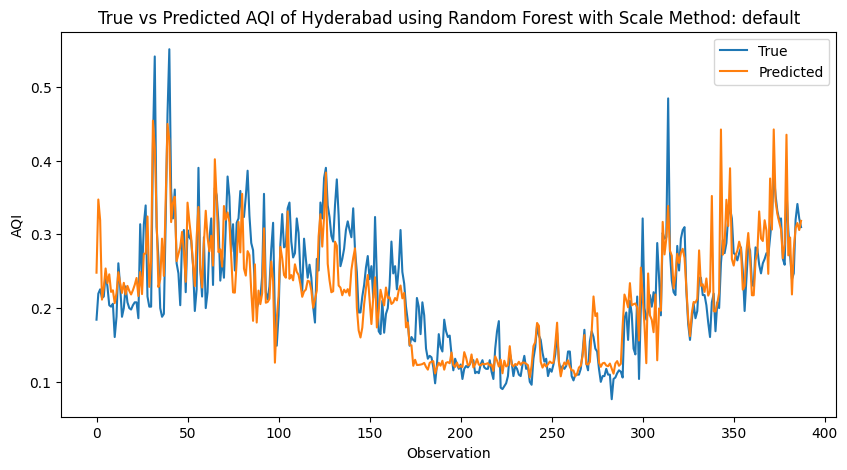

<ipython-input-24-4ecfe10499ed>:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y_train)
<ipython-input-24-4ecfe10499ed>:15: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100



 For Model: Random Forest with Scale Method: minmax
Mean Squared Error: 0.0015616732623250583
R-squared: 0.7497447839857297
Mean Absolute Error: 0.03085105836457189
Mean Absolute Percentage Error: inf


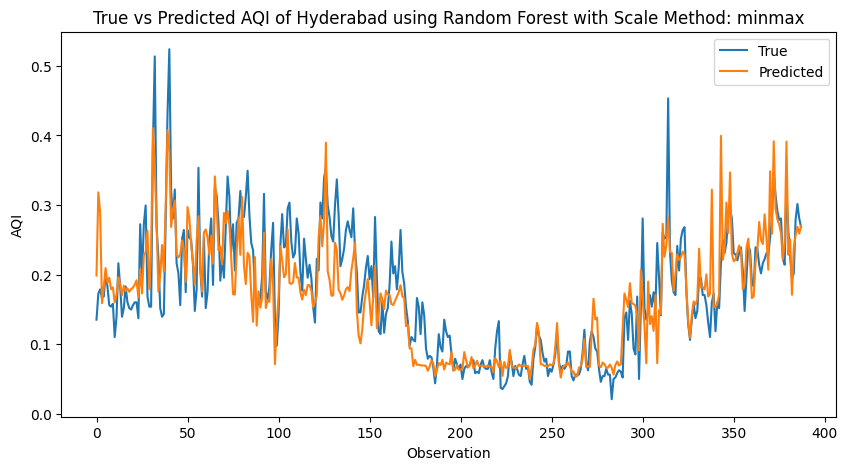

<ipython-input-24-4ecfe10499ed>:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y_train)



 For Model: Random Forest with Scale Method: maxabs
Mean Squared Error: 0.0013468717428253734
R-squared: 0.7573560850844152
Mean Absolute Error: 0.028744870921341467
Mean Absolute Percentage Error: 52.19032392436978


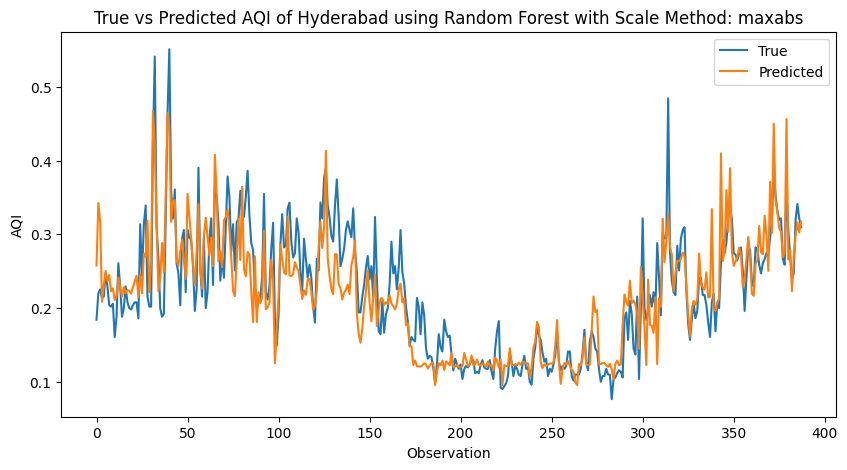

31/31 [==============================] - 0s 5ms/step

 For Model: Neural Network with Scale Method: default
Mean Squared Error: 0.005393525716493791
R-squared: 0.8231391900753364
Mean Absolute Error: 0.06342701467957193
Mean Absolute Percentage Error: 75.56725357165655


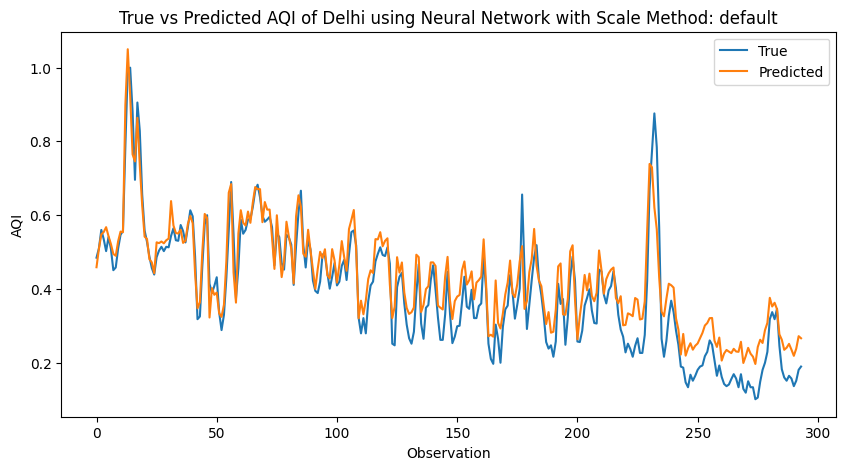

Epoch 78: early stopping
31/31 [==============================] - 0s 2ms/step

 For Model: Neural Network with Scale Method: minmax
Mean Squared Error: 0.00834307779401059
R-squared: 0.7660858587137438
Mean Absolute Error: 0.07846050210733836
Mean Absolute Percentage Error: inf


<ipython-input-25-2392b7932ae4>:22: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100


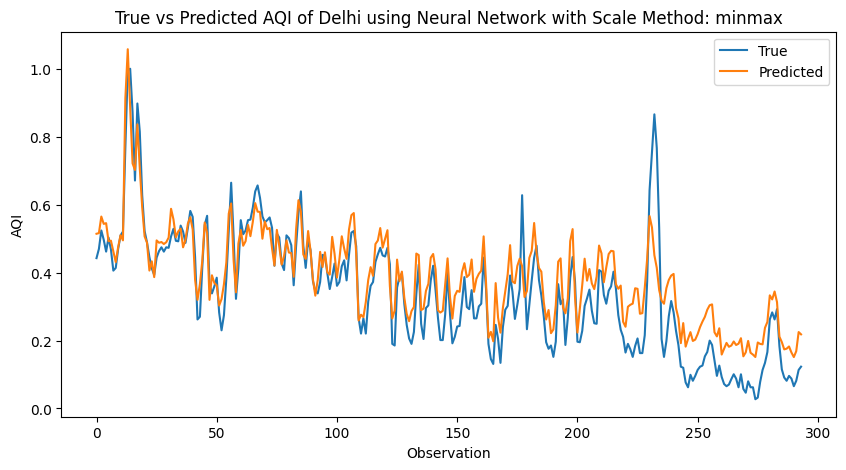

Epoch 96: early stopping
31/31 [==============================] - 0s 2ms/step

 For Model: Neural Network with Scale Method: maxabs
Mean Squared Error: 0.005998938832529528
R-squared: 0.80328689685021
Mean Absolute Error: 0.06486662518093475
Mean Absolute Percentage Error: 27.28320402456685


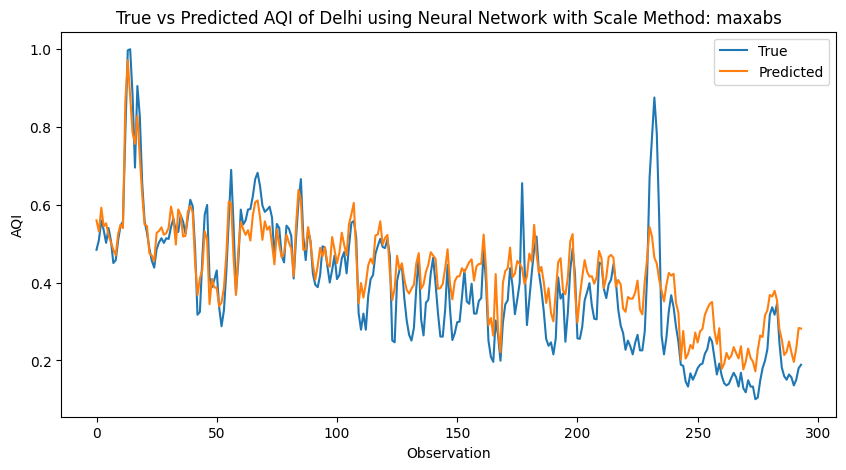

Epoch 50: early stopping
3/3 [==============================] - 0s 3ms/step

 For Model: Neural Network with Scale Method: default
Mean Squared Error: 0.01393754651338503
R-squared: 0.20216248274278503
Mean Absolute Error: 0.09101392290531059
Mean Absolute Percentage Error: 24.759092721398662


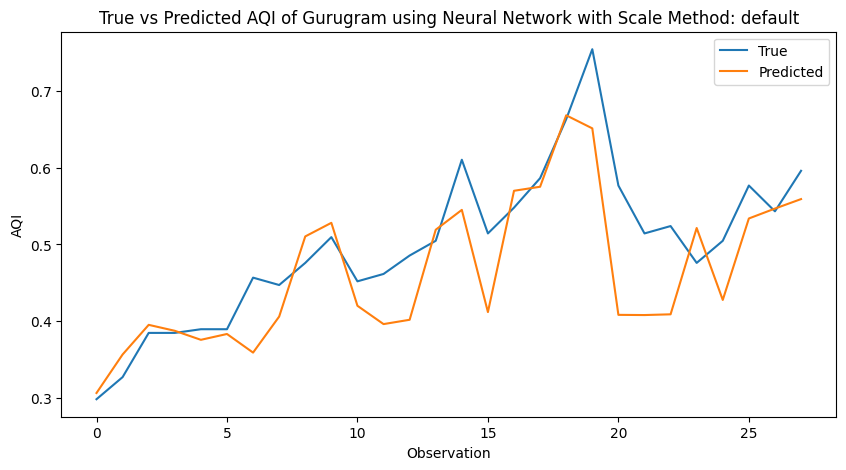

Epoch 65: early stopping
3/3 [==============================] - 0s 3ms/step

 For Model: Neural Network with Scale Method: minmax
Mean Squared Error: 0.021004543275616693
R-squared: 0.3829970586768129
Mean Absolute Error: 0.10954920833949124
Mean Absolute Percentage Error: 28.41747368636221


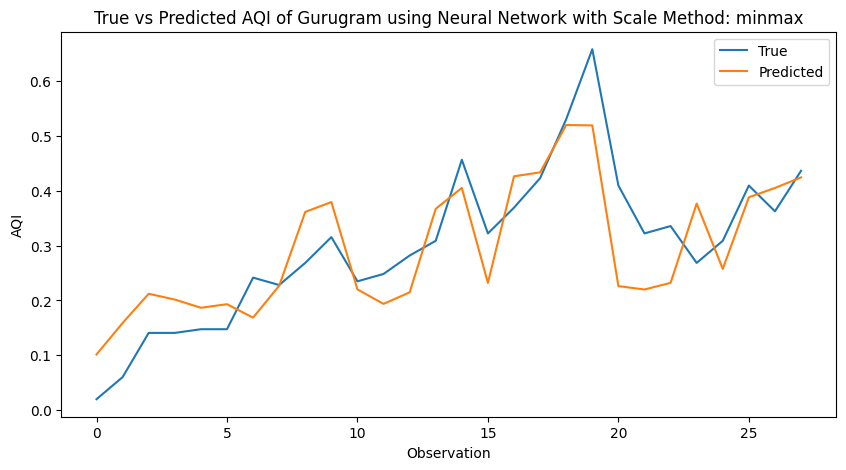

Epoch 32: early stopping
3/3 [==============================] - 0s 3ms/step

 For Model: Neural Network with Scale Method: maxabs
Mean Squared Error: 0.020076534176401307
R-squared: -0.14925623150723255
Mean Absolute Error: 0.11604893959772129
Mean Absolute Percentage Error: 18.231155028061664


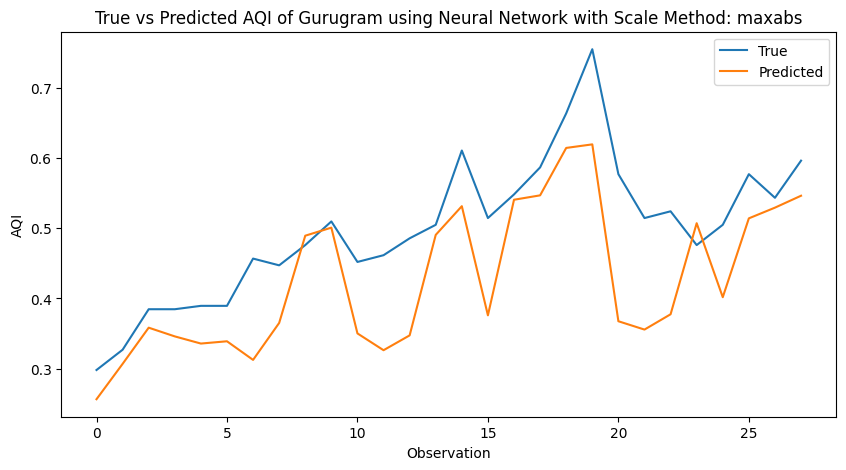

Epoch 32: early stopping


41/41 [==============================] - 1s 11ms/step

 For Model: Neural Network with Scale Method: default
Mean Squared Error: 0.0021431509595351596
R-squared: 0.6139034456348188
Mean Absolute Error: 0.040685090991827814
Mean Absolute Percentage Error: 57.56859357169889


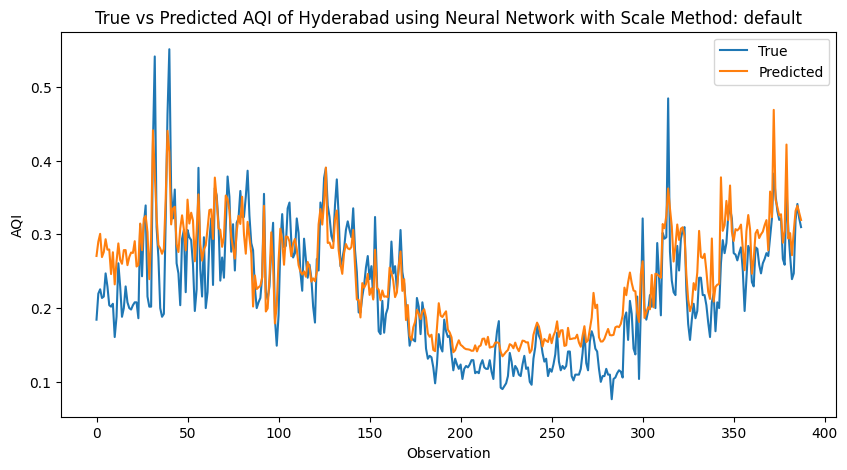

KeyboardInterrupt: 

In [33]:
# models = ['linear', 'rf', 'nn', 'lstm', 'rnn', 'ltc']
models = ['linear', 'rf', 'nn', 'lstm', 'rnn']
for model in models:
    run_all_methods_on_model(delhi, model, data_split=0.2, plot_split=0.3, city="Delhi")
    run_all_methods_on_model(gurugram, model, data_split=0.2, plot_split=0.3, city="Gurugram")
    run_all_methods_on_model(hyderabad, model, data_split=0.2, plot_split=0.3, city="Hyderabad")
    # run_all_methods_on_model(kolkata, model, data_split=0.2, plot_split=0.3, city="Kolkata")
    # run_all_methods_on_model(patna, model, data_split=0.2, plot_split=0.3, city="Patna")
    # run_all_methods_on_model(visakhapatnam, model, data_split=0.2, plot_split=0.3, city="Visakhapatnam")
    # run_all_methods_on_model(amaravati, model, data_split=0.2, plot_split=0.3, city="Amaravati")
    # run_all_methods_on_model(amritsar, model, data_split=0.2, plot_split=0.3, city="Amritsar")
    # run_all_methods_on_model(chandigarh, model, data_split=0.2, plot_split=0.3, city="Chandigarh")

In [ ]:
run_all_methods_on_model(delhi, "LTC", data_split=0.2, plot_split=0.3, city="Delhi")

In [ ]:
run_all_methods_on_model(gurugram, "LTC", data_split=0.2, plot_split=0.3, city="Gurugram")

In [ ]:
run_all_methods_on_model(hyderabad, "LTC", data_split=0.2, plot_split=0.3, city="Hyderabad")

In [ ]:
from google.colab import files
files.download('/content/results.csv')